# Backtest Kernel - DEMO

In [1]:
%matplotlib inline

from kernel import *
from oanda import *
from plotting import *

api = OANDAClient(OANDAPracticeConfig())
df = api.get_bars('EUR_USD', 'M30', 5000)
df.tail()

,closeMid,complete,datetime,highMid,lowMid,openMid,time,volume
4995,1.139375,True,2015-10-13 20:00:00,1.139425,1.138385,1.138385,1444780800000000,158
4996,1.139650,True,2015-10-13 20:30:00,1.139660,1.139115,1.139400,1444782600000000,198
4997,1.139505,True,2015-10-13 21:00:00,1.140135,1.139475,1.139680,1444784400000000,237
4998,1.139230,True,2015-10-13 21:30:00,1.139540,1.138505,1.139540,1444786200000000,373
4999,1.138980,False,2015-10-13 22:00:00,1.139540,1.138720,1.139260,1444788000000000,92


##Toy Strategy: DMA with Take_Profit/Stop_Loss

In [2]:
class DMA(StrategyTemplate):
    """
    DMA

    """

    def __init__(self, fast, slow, instrument='EUR_USD'):
        """

        """
        self.instrument = instrument
        self.history = []
        self.slow = slow
        self.fast = fast
        self.has_long = 0
        self.open_price = 0
        self.take_profit = 0

    def on_bar(self, bar):
        """
        Receive one bar, return signal, volume.
        :param bar: dict;
        :return: OrderType(Enum) object.
        """

        self.history.append(bar)
        curr_price = bar[BarColNames.close.value]
        # ---------------------------- #
        slow = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.slow:]])
        fast = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.fast:]])
        if fast > slow and (not self.has_long):
            self.has_long = 1
            self.open_price = curr_price
            return OrderType.buy, 10000
        if fast > slow and curr_price - self.open_price >= 0.01:  # take profit
            self.has_long = 1
            self.open_price = 0
            return OrderType.sell, 10000
        if curr_price - self.open_price <= -0.005:  # stop loss
            self.has_long = 1
            self.open_price = 0
            return OrderType.sell, 10000
        elif fast < slow:
            self.has_long = 0
            return OrderType.sell, 10000

        # ---------------------------- #
        return OrderType.none, 0


##Report

* plotting.report()

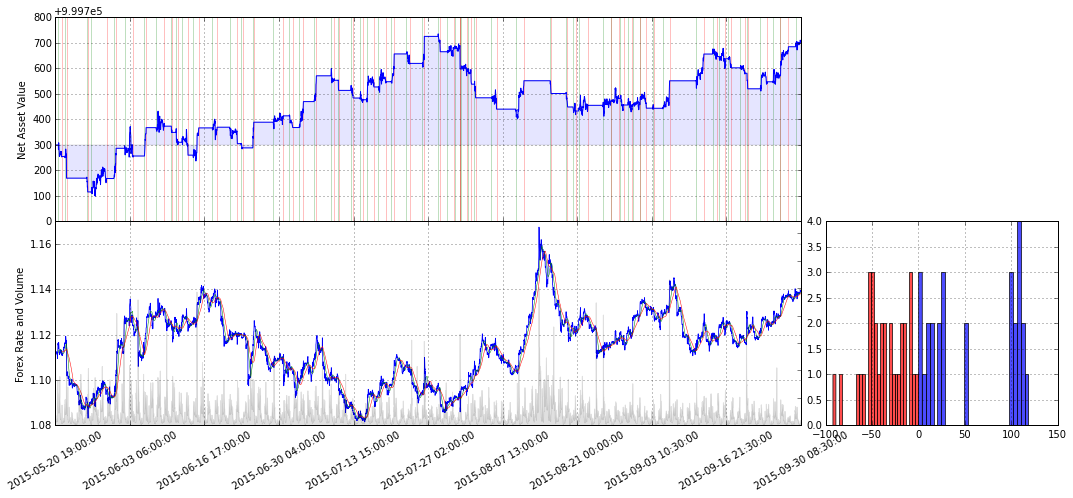

In [3]:
# Toy strategy


k = Kernel.naive(df)
s = DMA(20,45)
k.run_naive(s)
ax1,ax2,ax3 = report(k,ma1=20,ma2=45)


##Export executed orders
* Kernel.export_executed_orders()

In [4]:
k.export_executed_orders().head(10)

,direction,instrument,price,target,time,volume
0,OrderType.buy,EUR_USD,1.120105,None,2015-05-05 12:30:00,10000
1,OrderType.sell,EUR_USD,1.133455,None,2015-05-06 09:30:00,10000
2,OrderType.buy,EUR_USD,1.117625,None,2015-05-12 01:30:00,10000
3,OrderType.sell,EUR_USD,1.121995,None,2015-05-12 21:30:00,10000
4,OrderType.buy,EUR_USD,1.125085,None,2015-05-13 03:30:00,10000
5,OrderType.sell,EUR_USD,1.135805,None,2015-05-13 11:00:00,10000
6,OrderType.buy,EUR_USD,1.140335,None,2015-05-14 21:00:00,10000
7,OrderType.sell,EUR_USD,1.135990,None,2015-05-15 04:30:00,10000
8,OrderType.buy,EUR_USD,1.145140,None,2015-05-15 15:00:00,10000
9,OrderType.sell,EUR_USD,1.139545,None,2015-05-18 03:00:00,10000


##Export positions
* Kernel.export_positions()

In [5]:
k.export_positions().head(10)

,close_price,close_time,direction,instrument,open_price,open_time,realized_pnl,volume
0,1.133455,2015-05-06 09:30:00,PositionType.long,EUR_USD,1.120105,2015-05-05 12:30:00,133.50,10000
1,1.121995,2015-05-12 21:30:00,PositionType.long,EUR_USD,1.117625,2015-05-12 01:30:00,43.70,10000
2,1.135805,2015-05-13 11:00:00,PositionType.long,EUR_USD,1.125085,2015-05-13 03:30:00,107.20,10000
3,1.135990,2015-05-15 04:30:00,PositionType.long,EUR_USD,1.140335,2015-05-14 21:00:00,-43.45,10000
4,1.139545,2015-05-18 03:00:00,PositionType.long,EUR_USD,1.145140,2015-05-15 15:00:00,-55.95,10000
5,1.111220,2015-05-21 16:30:00,PositionType.long,EUR_USD,1.112235,2015-05-20 23:00:00,-10.15,10000
6,1.107970,2015-05-22 08:30:00,PositionType.long,EUR_USD,1.116445,2015-05-22 03:00:00,-84.75,10000
7,1.086200,2015-05-27 07:30:00,PositionType.long,EUR_USD,1.091595,2015-05-27 04:00:00,-53.95,10000
8,1.095255,2015-05-31 23:00:00,PositionType.long,EUR_USD,1.090005,2015-05-27 19:00:00,52.50,10000
9,1.104440,2015-06-02 07:00:00,PositionType.long,EUR_USD,1.092585,2015-06-01 23:00:00,118.55,10000


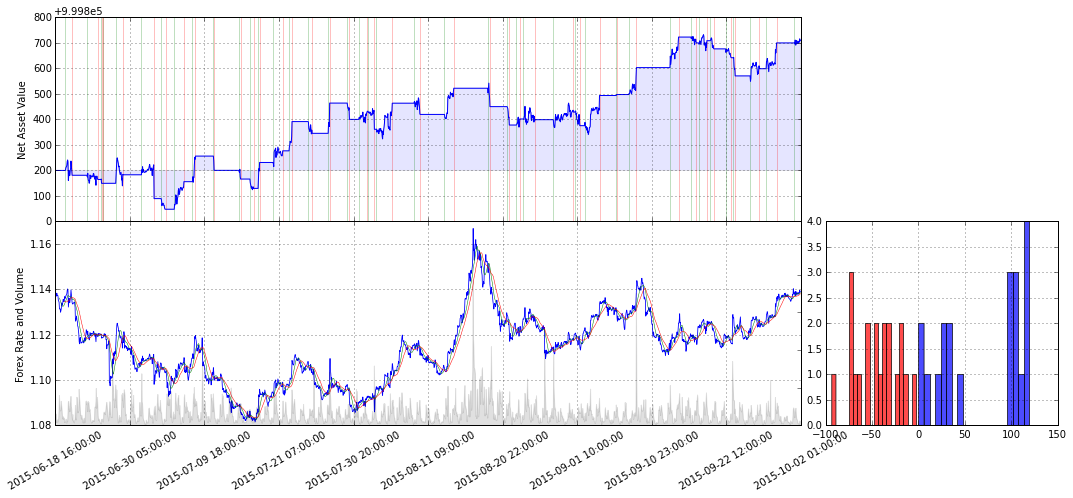

In [4]:
s2 = DMA(12,25)
k = Kernel.naive(api.get_bars('EUR_USD', 'H1', 2000))
k.run_naive(s2)
ax1,ax2,ax3 = report(k,ma1=12,ma2=25)

In [5]:
class DMA_200(StrategyTemplate):
    """
    DMA_200

    """

    def __init__(self, fast, slow=200, instrument='EUR_USD'):
        """

        """
        self.instrument = instrument
        self.history = []
        self.slow = slow
        self.fast = fast
        self.has_long = 0
        self.open_price = 0
        self.take_profit = 0

    def on_bar(self, bar):
        """
        Receive one bar, return signal, volume.
        :param bar: dict;
        :return: OrderType(Enum) object.
        """

        self.history.append(bar)
        curr_price = bar[BarColNames.close.value]
        # ---------------------------- #
        slow = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.slow:]])
        fast = np.mean([b[BarColNames.close.value]
                        for b in self.history[-1*self.fast:]])
        if fast > slow and (not self.has_long):
            self.has_long = 1
            self.open_price = curr_price
            return OrderType.buy, 10000
        elif fast < slow:
            self.has_long = 0
            return OrderType.sell, 10000

        # ---------------------------- #
        return OrderType.none, 0


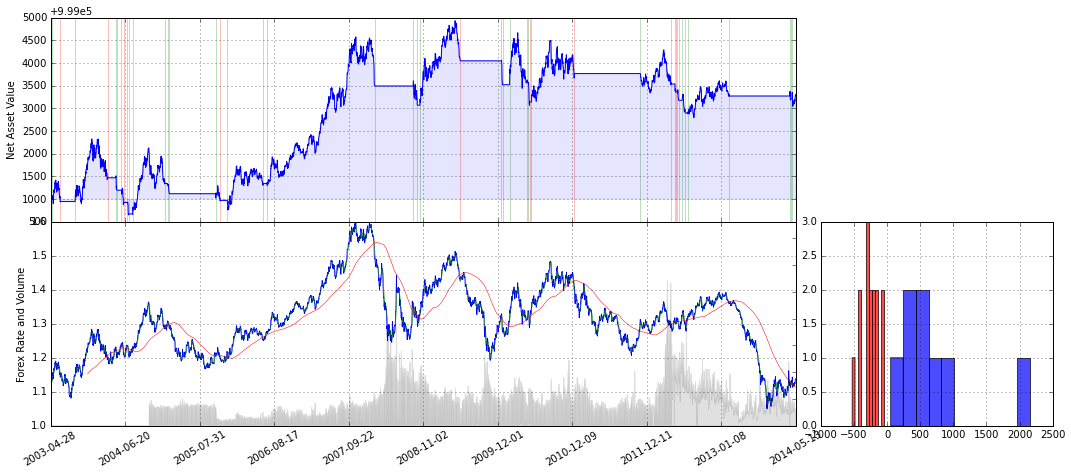

In [6]:
s3 = DMA_200(10)
k = Kernel.naive(api.get_bars('EUR_USD', 'D', 4000))
k.run_naive(s3)
ax1,ax2,ax3 = report(k,ma1=7,ma2=200)

In [19]:
df = api.get_bars('EUR_USD', 'H1', 2000)
pnl_list = []
for fast in range(10,60):
    s2 = DMA(12,fast)
    k = Kernel.naive(df)
    pnl_list.append(k.run_naive(s2)[-1])
    print "Finished Simulation: MA2={}".format(fast)
pnl_list


Finished Simulation: MA2=10
Finished Simulation: MA2=11
Finished Simulation: MA2=12
Finished Simulation: MA2=13
Finished Simulation: MA2=14
Finished Simulation: MA2=15
Finished Simulation: MA2=16
Finished Simulation: MA2=17
Finished Simulation: MA2=18
Finished Simulation: MA2=19
Finished Simulation: MA2=20
Finished Simulation: MA2=21
Finished Simulation: MA2=22
Finished Simulation: MA2=23
Finished Simulation: MA2=24
Finished Simulation: MA2=25
Finished Simulation: MA2=26
Finished Simulation: MA2=27
Finished Simulation: MA2=28
Finished Simulation: MA2=29
Finished Simulation: MA2=30
Finished Simulation: MA2=31
Finished Simulation: MA2=32
Finished Simulation: MA2=33
Finished Simulation: MA2=34
Finished Simulation: MA2=35
Finished Simulation: MA2=36
Finished Simulation: MA2=37
Finished Simulation: MA2=38
Finished Simulation: MA2=39
Finished Simulation: MA2=40
Finished Simulation: MA2=41
Finished Simulation: MA2=42
Finished Simulation: MA2=43
Finished Simulation: MA2=44
Finished Simulation:

[999820.7000000002,
 999644.0000000001,
 1000000,
 1000002.1,
 1000147.6000000003,
 1000055.4000000001,
 999824.2,
 1000203.3000000007,
 1000211.3000000003,
 1000450.6,
 1000478.0500000003,
 1000282.3999999999,
 1000191.0500000002,
 1000278.7000000003,
 1000410.6,
 1000508.2499999999,
 1000399.65,
 1000319.6000000001,
 1000491.7000000003,
 1000378.9000000004,
 1000453.8500000003,
 1000514.9500000003,
 1000659.3,
 1000561.8,
 1000653.15,
 1000595.3499999999,
 1000533.0499999999,
 1000182.4999999999,
 1000193.4,
 1000057.5499999999,
 1000030.6000000001,
 1000093.6000000001,
 1000125.15,
 1000062.75,
 1000136.7499999999,
 1000118.3500000001,
 1000120.65,
 1000278.6,
 1000337.75,
 1000211.0,
 1000185.1499999999,
 1000195.75,
 1000265.1999999998,
 1000026.5499999998,
 1000296.6499999999,
 1000294.5499999998,
 1000201.55,
 1000114.75,
 1000071.3999999999,
 1000056.3]

In [9]:
range(25,30)

[25, 26, 27, 28, 29]

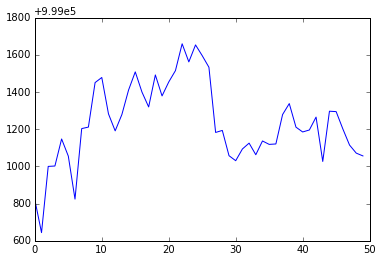

In [20]:
plt.plot(pnl_list)

In [48]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


Z = numpy.zeros(shape=(30,30))

df = api.get_bars('EUR_USD', 'H1', 2000)
slow = 10
delta_fast = 6
for i in range(0, 30):
    delta_fast = 6
    slow = slow + 1
    for j in range(0,30):
        delta_fast += 2
        fast = slow + delta_fast
        s2 = DMA(slow,slow+delta_fast)
        k = Kernel.naive(df)
        Z[i][j] = k.run_naive(s2)[-1]
        print "Finished Simulation: {},{}".format(i,j)
Z

Finished Simulation: 0,0
Finished Simulation: 0,1
Finished Simulation: 0,2
Finished Simulation: 0,3
Finished Simulation: 0,4
Finished Simulation: 0,5
Finished Simulation: 0,6
Finished Simulation: 0,7
Finished Simulation: 0,8
Finished Simulation: 0,9
Finished Simulation: 0,10
Finished Simulation: 0,11
Finished Simulation: 0,12
Finished Simulation: 0,13
Finished Simulation: 0,14
Finished Simulation: 0,15
Finished Simulation: 0,16
Finished Simulation: 0,17
Finished Simulation: 0,18
Finished Simulation: 0,19
Finished Simulation: 0,20
Finished Simulation: 0,21
Finished Simulation: 0,22
Finished Simulation: 0,23
Finished Simulation: 0,24
Finished Simulation: 0,25
Finished Simulation: 0,26
Finished Simulation: 0,27
Finished Simulation: 0,28
Finished Simulation: 0,29
Finished Simulation: 1,0
Finished Simulation: 1,1
Finished Simulation: 1,2
Finished Simulation: 1,3
Finished Simulation: 1,4
Finished Simulation: 1,5
Finished Simulation: 1,6
Finished Simulation: 1,7
Finished Simulation: 1,8
Finis

array([[ 1000327.55,  1000301.9 ,  1000437.9 ,  1000113.45,  1000311.3 ,
         1000511.75,  1000470.3 ,  1000503.75,  1000777.5 ,  1000807.35,
         1000268.05,  1000292.65,  1000146.5 ,  1000117.3 ,  1000048.1 ,
          999982.55,  1000341.55,  1000267.7 ,  1000353.6 ,  1000342.35,
         1000153.5 ,  1000069.55,  1000015.8 ,  1000045.1 ,  1000069.3 ,
          999818.8 ,   999793.55,   999794.65,   999792.4 ,   999811.6 ],
       [ 1000483.05,  1000196.05,  1000415.6 ,  1000404.65,  1000496.7 ,
         1000458.85,  1000664.3 ,  1000658.15,  1000538.05,  1000198.4 ,
         1000035.6 ,  1000130.15,  1000141.75,  1000125.65,  1000342.75,
         1000190.15,  1000265.2 ,  1000296.65,  1000201.55,  1000071.4 ,
         1000061.3 ,  1000019.3 ,  1000053.55,   999888.85,   999898.6 ,
          999837.9 ,   999967.55,   999933.2 ,   999979.  ,   999863.2 ],
       [ 1000325.  ,  1000300.45,  1000299.35,  1000386.9 ,  1000172.2 ,
         1000432.55,  1000497.35,  1000703.8 ,   

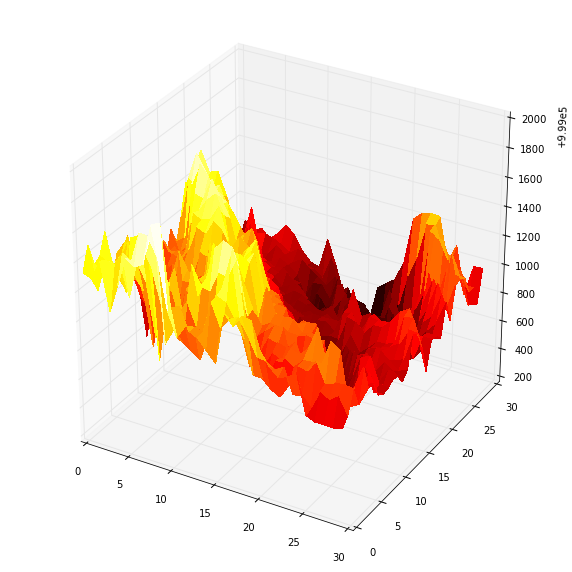

In [49]:
X = np.arange(0, 30)
Y = np.arange(0, 30)
X, Y = np.meshgrid(X, Y) 
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)

In [37]:
X = np.arange(0, 20)
len(X)

20

In [50]:
import scipy.io
scipy.io.savemat('Z2.mat', mdict={'Z': Z})